# Human Emotions Recognition



## Project Description

Current project was done within Advanced Programming and Deep Learning for AI course at Universita Cattolica Santo Cuore taugth by Pr. Jianyi Lin.

Data is taken from Coursera (https://www.kaggle.com/datasets/samithsachidanandan/human-face-emotions). License
Apache 2.0

This dataset contains three folders: Angry, Fear, Happy, Sad, and Surprised. Each folder contains around 8000+ images of each expression.

## Libraries Import

In [43]:
%pip install -q torch torchvision
%pip install -q d2l==1.0.0a1.post0

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [56]:
%matplotlib inline

import time
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils import data
from torchvision import transforms, datasets
from torch.utils.data import random_split

from d2l import torch as d2l

import torch.nn as nn

from PIL import Image
import os

d2l.use_svg_display()

## Data Load & Description

How many images we have for each class:

In [55]:
root = '/Users/georgijkutivadze/Documents/Study/UCSC/2 Year/1 term/Advanced Programming and Deep Learning for AI/Prof. Jianyi Lin (Module II)/Project/Data'

image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

class_counts = {}

for class_name in os.listdir(root):
    class_dir = os.path.join(root, class_name)
    if not os.path.isdir(class_dir):
        continue  # skip files if any

    count = 0
    for fname in os.listdir(class_dir):
        _, ext = os.path.splitext(fname)
        if ext.lower() in image_exts:
            count += 1

    class_counts[class_name] = count

for cls, cnt in sorted(class_counts.items()):
    print(f"{cls}: {cnt}")

Angry: 10148
Fear: 9732
Happy: 18439
Sad: 12553
Suprise: 8227


Check random image:

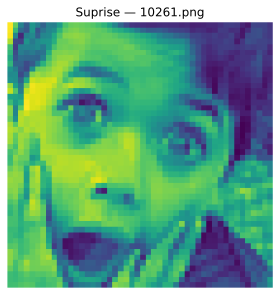

In [65]:
classes = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

random_class = random.choice(classes)

image_dir = os.path.join(root, random_class)
images = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in image_exts]

random_image = random.choice(images)
image_path = os.path.join(image_dir, random_image)

img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"{random_class} — {random_image}")
plt.show()

## Data Preparation

In [26]:
# just for example, apply these transformations: take a random crop, flip randomly, then convert RGB to grayscale
data_augmentation = transforms.Compose([
        #transforms.RandomResizedCrop(224), #crops a random part of the image and then resizes it to a size of 224x224 pixels.
        #transforms.RandomHorizontalFlip(),
        transforms.Resize((48, 48)),
        transforms.Grayscale(),
        transforms.ToTensor()
        #transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Practical tutorial from Pytorch: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
# Also check out the documentation of ImageFolder
# Note: each image (sub)folder is considered as one category
my_dataset = datasets.ImageFolder(root='/Users/georgijkutivadze/Documents/Study/UCSC/2 Year/1 term/Advanced Programming and Deep Learning for AI/Prof. Jianyi Lin (Module II)/Project/Data',
                                           transform=data_augmentation)

In [27]:
train_size = int(0.8 * len(my_dataset))
test_size = len(my_dataset) - train_size

train_dataset, test_dataset = random_split(my_dataset, [train_size, test_size])

In [28]:
train_iter = data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_iter  = data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

In [7]:
# dir(some_example_set.dataset) #The dir() function in python is an in-built function used on an object to look at all the properties / attributes and methods of that object

In [8]:
# #just for learning purposes
# data_iter = iter(some_example_set) #Create an iterator that will return batches from some_example_set when I call next().

In [9]:
# X, y = next(data_iter)  # get one minibatch
# print(my_dataset[0][0].shape)
# print(X.shape) # X is (batch_size, channels, img height, img width)
# print(X[0].shape) # one image in proper channel(s)
# print(y.shape)
# print(y) # y: 0-based index values representing class labels of the minibatch
# print(torch.is_tensor(X[0]))

In [10]:
# len(my_dataset[0])

In [11]:
print(type(my_dataset[0][0]))

<class 'torch.Tensor'>


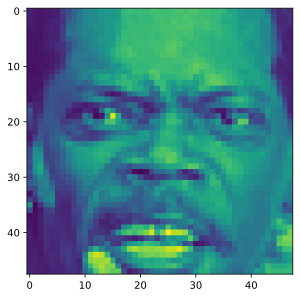

In [12]:
_ = plt.imshow(np.asarray(my_dataset[2][0][0])) # , cmap='gray'

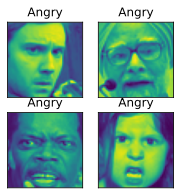

In [13]:
imgs = [my_dataset[i][0].permute(1, 2, 0) for i in range(4)]
labels = [my_dataset[i][1] for i in range(4)]

_ = d2l.show_images(imgs, 2, 2, titles=[my_dataset.classes[l] for l in labels])

## Baseline Model

In [14]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(48 * 48 * 1, 128),
    nn.ReLU(),
    nn.Linear(128, 48),
    nn.ReLU(),
    nn.Linear(48, 5)
)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2304, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=48, bias=True)
  (4): ReLU()
  (5): Linear(in_features=48, out_features=5, bias=True)
)

In [15]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) # initializes the weights of the linear layer using a normal distribution N(0, std)

model.apply(init_weights);

In [16]:
batch_size, lr, num_epochs = 256, 0.1, 5
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(model.parameters(), lr=lr)

In [17]:
def train_epoch(net, train_iter, loss, updater,
                device=None, epoch=None, num_epochs=None,
                log_interval=10):
    if isinstance(net, torch.nn.Module):
        net.train()

    if device is None:
        device = next(net.parameters()).device

    metric = d2l.Accumulator(3)
    total_batches = len(train_iter)

    for batch_i, (X, y) in enumerate(train_iter, start=1):
        X, y = X.to(device), y.to(device)

        y_hat = net(X)
        l = loss(y_hat, y)

        updater.zero_grad()
        l.backward()
        updater.step()

        metric.add(l.item() * y.size(0),
                   d2l.accuracy(y_hat, y),
                   y.numel())

        # лог по батчам
        if log_interval is not None and batch_i % log_interval == 0:
            if epoch is not None and num_epochs is not None:
                print(f"[epoch {epoch+1}/{num_epochs}] "
                      f"batch {batch_i}/{total_batches}, "
                      f"loss {l.item():.4f}")
            else:
                print(f"batch {batch_i}/{total_batches}, loss {l.item():.4f}")

    return metric[0] / metric[2], metric[1] / metric[2]

In [18]:
def train(net, train_iter, test_iter, loss, num_epochs, updater, device=None):
    if device is None:
        device = next(net.parameters()).device

    animator = d2l.Animator(
        xlabel='epoch',
        xlim=[1, num_epochs],
        ylim=[0.3, 0.9],
        legend=['train loss', 'train acc.', 'test acc.']
    )

    for epoch in range(num_epochs):
        train_metrics = train_epoch(
            net, train_iter, loss, updater,
            device=device,
            epoch=epoch, num_epochs=num_epochs,
            log_interval=10,        # каждые 10 батчей
        )
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        print(f"epoch {epoch+1}, "
              f"train loss {train_metrics[0]:.4f}, "
              f"train acc {train_metrics[1]:.3f}, "
              f"test acc {test_acc:.3f}")

    train_loss, train_acc = train_metrics
    return train_loss, train_acc

epoch 10, train loss 1.2960, train acc 0.468, test acc 0.426


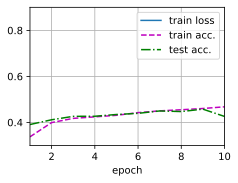

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_loss, train_acc = train(model, train_iter, test_iter,
                              loss, num_epochs, trainer, device=device)

## CNN

In [20]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            # Вход: (B, 1, 48, 48)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # -> (B, 16, 48, 48)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> (B, 16, 24, 24)

            nn.Conv2d(16, 32, kernel_size=3, padding=1), # -> (B, 32, 24, 24)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> (B, 32, 12, 12)

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> (B, 64, 12, 12)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # -> (B, 64, 6, 6)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                # -> (B, 64*6*6)
            nn.Linear(64 * 6 * 6, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)                  # -> (B, 5)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

epoch 10, train loss 0.7716, train acc 0.705, test acc 0.659


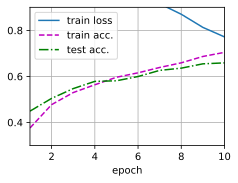

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNet(num_classes=5).to(device)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

train_loss, train_acc = train(model, train_iter, test_iter,
                              loss, num_epochs, trainer, device=device)

Let's try 30 epochs:

epoch 30, train loss 0.1139, train acc 0.968, test acc 0.855


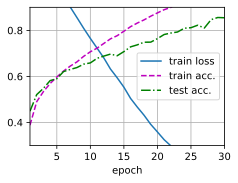

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 30
model = ConvNet(num_classes=5).to(device) 
trainer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss, train_acc = train(model, train_iter, test_iter,
                              loss, num_epochs, trainer, device=device)

## Applying Regularizstion (DropOut)

In [40]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            # Input: (B, 1, 48, 48)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),      # -> (B, 16, 24, 24)

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),      # -> (B, 32, 12, 12)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),      # -> (B, 64, 6, 6)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 128),
            nn.ReLU(),
            nn.Dropout(0.5),          # Dropout
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

epoch 30, train loss 0.4466, train acc 0.813, test acc 0.806


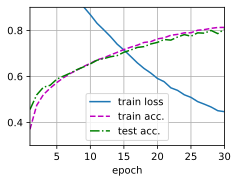

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ConvNet(num_classes=5).to(device)

loss = nn.CrossEntropyLoss()
trainer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 30

train_loss, train_acc = train(
    model, train_iter, test_iter,
    loss, num_epochs, trainer, device=device
)

# New Prediction

In [46]:
class_names = my_dataset.classes
class_names

['Angry', 'Fear', 'Happy', 'Sad', 'Suprise']

In [47]:
def predict_image(img_path, model, transform, class_names, device):
    model.eval()

    img = Image.open(img_path).convert('RGB')

    x = transform(img)          # (1, 48, 48)
    x = x.unsqueeze(0).to(device)  # adding batch: (1, 1, 48, 48)

    with torch.no_grad():
        logits = model(x)                 # (1, num_classes)
        probs = torch.softmax(logits, 1)  # probs
        pred_idx = probs.argmax(1).item()
        pred_class = class_names[pred_idx]
        pred_prob = probs[0, pred_idx].item()

    return pred_class, pred_prob

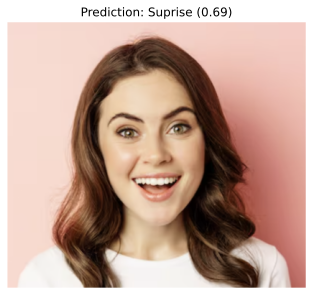

In [68]:
data_root = '/Users/georgijkutivadze/Documents/Study/UCSC/2 Year/1 term/Advanced Programming and Deep Learning for AI/Prof. Jianyi Lin (Module II)/Project/Data'
parent_dir = os.path.dirname(data_root)

img_path = os.path.join(parent_dir, 'surprised_woman.png')

class_names = my_dataset.classes

pred_class, pred_prob = predict_image(
    img_path, model, data_augmentation, class_names, device
)

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_class} ({pred_prob:.2f})")
plt.show()

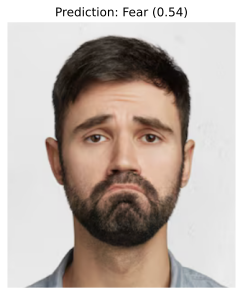

In [69]:
img_path = os.path.join(parent_dir, 'sad_man.png')

pred_class, pred_prob = predict_image(
    img_path, model, data_augmentation, class_names, device
)

img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_class} ({pred_prob:.2f})")
plt.show()

## Confusion Marix

In [51]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in test_iter:
        X = X.to(device)
        y = y.to(device)

        y_hat = model(X)             
        preds = y_hat.argmax(1)       

        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

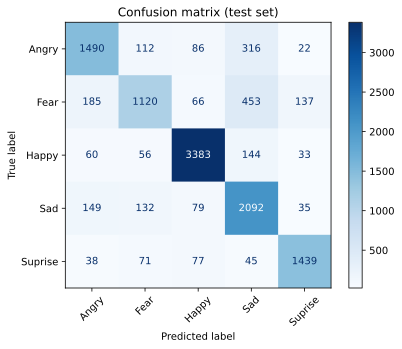

In [53]:
class_names = my_dataset.classes

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion matrix (test set)")
plt.show()

## Save model

In [70]:
# torch.save(model.state_dict(), "emotion_cnn.pth")